# Tutorial for using detectors in the structural-color package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Introduction to how detectors are implemented in the package

#### Single scattering model
TODO: add description and examples for detection in single scattering model

#### Monte Carlo model
In the Monte Carlo model, the detector first comes into play in calculating reflectance or transmittance using the calc_refl_trans() function. If no detector parameters are specified in the arguments of the function, the reflectance and transmittance returned are the reflectance integrated over the total reflection hemisphere and the transmittance integrated over the total transmittance hemisphere. 

There are two ways to change the type of detection used to calculate reflectance. At this time, the detectors aren't implemented for transmittance, but it is certainly possible to implement them in the future. The different detectors and how to use them are explained below. 

### Loading and using the package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
from structcol import refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
import pymie as pm
from pymie import size_parameter, index_ratio 
import time

# For Jupyter notebooks only:
%matplotlib inline

### Run Monte Carlo trajectories
#### for a single wavelength

set system parameters

In [2]:
# incident light wavelength
wavelength = sc.Quantity('600 nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-4*1j
n_particle = ri.n('polystyrene', wavelength) + n_imag    # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelength)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelength)      # space within sample. n_medium is outside the sample
n_sample = ri.n_eff(n_particle,         # refractive index of sample, calculated using Bruggeman approximation
                    n_matrix, 
                    volume_fraction)
thickness = sc.Quantity('80 um')
boundary = 'film'

# Monte Carlo parameters
ntrajectories = 300                   # number of trajectories
nevents = 200                         # number of scattering events in each trajectory

initialize and run trajectories

In [3]:
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelength)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, boundary)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

/Users/vhwang/anaconda/lib/python3.5/site-packages/pint/quantity.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


### Calculate reflectance with default detector
This calculates the reflectance for the full reflection hemisphere

In [4]:
# Calculate reflectance
reflectance, _ = det.calc_refl_trans(trajectories, thickness, n_medium, n_sample, boundary)

print('Reflectance = '+ str(reflectance))

Reflectance = 0.43075233384400846


### Calculate reflectance with large aperture detector
This detects only the trajectories that exit at an angle less than or equal to a specified detection angle.

To use this detector, you must specify an extra parameter in the calc_refl_trans() function:

##### detection_angle [structural color Quantity, angle]
This is the maximum angle that is detected. It is defined relative to the vector normal to surface of the sample. For example, a detection angle of 0 degrees corresponds to no angles detected,
and a detection angle of 90 degrees corresponds to the full reflection hemisphere.


In [5]:
# Set detector parameter
detection_angle = sc.Quantity('80 degrees')

# Calculate reflectance
reflectance, _ = det.calc_refl_trans(trajectories, thickness, n_medium, n_sample, boundary,
                                                detection_angle = detection_angle)

print('Reflectance = '+ str(reflectance))

Reflectance = 0.4213179588901466


### Calculate reflectance with goniometer detector
This detects only the trajectories that exit into a detector aperture with a specified size and position. The detector is modeled after a goniometer detector, which is on an arm of fixed length that can rotate around the sample in the center. 

To use this detector, you must specify 4 (optionally 5) parameters to be passed into calc_refl_trans().
1. detector [boolean]
<br>
This must be set to True.
<br>
<br>
2. det_theta [structural color Quantity, angle]
<br>
This is the angle that the detector is centered at. The angle is defined relative to the vector normal to the surface of the sample. For example a det_theta of 0 degrees would correspond to a detector normal to the sample, and a det_theta of 90 degrees would correspond to a detector at the side of the sample. 
<br>
<br>
3. det_len [structural color Quantity, length]
<br>
This is the side length of the detector, assuming a square detector
<br>
<br>
4. det_dist [structural color Quantity, length]
<br>
This is the distance between the center of the detector detector and the center of the sample surface.
<br>
<br>
5. plot_detector [boolean, optional]
<br>
This can be set to True to plot the exit positions of the trajectories in the detection hemisphere, with detected trajectories encirled in an orange ring. 
<br>
<br>

Reflectance = 0.018964604081459342


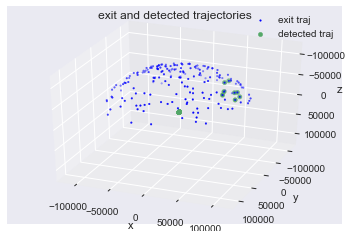

In [6]:
# Set detector parameters
detector = True
det_theta = sc.Quantity('45 degrees')
det_len = sc.Quantity('5 cm')
det_dist = sc.Quantity('10 cm')
plot_detector = True

# Calculate reflectance
reflectance, _ = det.calc_refl_trans(trajectories, thickness, n_medium, n_sample, boundary,
                                    detector = detector,
                                    det_theta = det_theta,
                                    det_len = det_len,
                                    det_dist = det_dist,
                                    plot_detector = plot_detector)

print('Reflectance = '+ str(reflectance))

### Renormalizing goniometer detector results

Because detection in a small angle range can lead to very small reflectances, it can be useful to normalize to the reflectance of a lambertian reflector for the given angle detector range, rather than to the total beam intensity. This will lead to results that can more easily be converted to a color for visualization. 

This normalization scheme makes several key assumptions:
1. The area of the detection hemisphere spanned by the detector aperture is
   a square. As the detector size approaches the diameter of the detection
   hemisphere, this assumption becomes worse. In reality, the detection hemisphere
   area spanned by the detector is the projection of a square on the sphere
   surface, which looks like a curved square patch.
2. The reference reflector (maximum reflectance) is that of a lambertian
   reflector, meaning the reflectance is uniform over the detection hemisphere
   and that the integrated reflected intensity is equal to the intensity 
   of the incident beam. This means that if the sample has a specular 
   component, the reflectance could be greater than one for the specular angle.
        
The normalization formula is:

refl_renormlized = $\frac{\textsf{area of detection hemisphere}}{\textsf{(area detected) * reflectance}}$  

We are just scaling up the reflectance based on the area detected relative to the total possible area that can be detected.      

In [7]:
refl_renorm = det.normalize_refl_goniometer(reflectance, det_dist, det_len)

print('Renormalized Reflectance: ' + str(refl_renorm))

Renormalized Reflectance: 0.4766324868844134 dimensionless
